In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import MinMaxScaler

dataset_name = 'dataset.csv'

# Reading dataset from file
input_df = pd.read_csv('data/' + dataset_name, index_col = 0).sort_values(['t', 'x'])
input_df = input_df.reset_index()

# Preprocessing data

known_val_indeces = input_df[input_df["k"] == 1].index
unknown_val_indeces = input_df[input_df["k"] == 0].index

t_data = input_df[["t"]]
t_scaler = MinMaxScaler()
t_train = pd.DataFrame(t_scaler.fit_transform(t_data), columns = ["t"])

x_data = input_df[["x"]]
x_scaler = MinMaxScaler()
x_train = pd.DataFrame(x_scaler.fit_transform(x_data), columns = ["x"])

theta_data = input_df[["theta"]]
theta_scaler = MinMaxScaler()
theta_train = pd.DataFrame(theta_scaler.fit_transform(theta_data), columns = ["theta"])
theta_train.iloc[unknown_val_indeces] = np.nan


In [8]:
import tensorflow as tf
import tensorflow.keras.backend as K

def custom_mean_squared_error(y_true, y_pred):

    tmp = tf.math.multiply(y_true, y_pred)
    
    is_not_nan = tf.cast((tmp == tmp), tf.bool)
    
    indeces = tf.where(is_not_nan)
    
    result = tf.math.reduce_mean(tf.math.square(tf.gather_nd(y_true, indeces) - tf.gather_nd(y_pred, indeces)))
    return result

def F(alpha, x_source = 0.0, Q_source = 0.0):
    
    theta = model.output
    t = model.input[0]
    x = model.input[1]
    
    #print(tf.keras.backend.gradients(theta, t))
    #print(tf.keras.backend.gradients(theta, x))
    theta_t = tf.keras.backend.gradients(theta, t)[0]
    theta_x = tf.keras.backend.gradients(theta, x)[0]
    theta_xx = tf.keras.backend.gradients(theta_x, x)[0]
    
    f = theta_t - alpha*theta_xx - Q_source * tf.cast((x == x_source), tf.float32)
    
    return f

def custom_loss(alpha, x_source = 0.0, Q_source = 0.0):
    
    def loss(y_true,y_pred):
        
        MSE = custom_mean_squared_error(y_true, y_pred)
        return tf.math.square(F(alpha, x_source, Q_source))
    
    return loss

alpha = 10.0
x_source = 0.5
Q_source = 1.0

class myLossFunc(tf.keras.losses.Loss):
    def __init__(self, alpha, x_source = 0.0, Q_source = 0.0, 
                 reduction = tf.keras.losses.Reduction.AUTO,
                 name='myLoss'):
        super(myLossFunc, self).__init__(reduction=reduction, name=name)
        self.alpha = alpha
        self.x_source = x_source
        self.Q_source = Q_source
        
    def call(self, y_true, y_pred):
        MSE = custom_mean_squared_error(y_true, y_pred)
        f = tf.math.square(F(self.alpha, self.x_source, self.Q_source))
        return f

class CustomModel(tf.keras.Model):
    def train_step(self, data):
        t, x, theta = data

        with tf.GradientTape() as tape:
            theta_pred = self([t, x], training=True)
            
            # Compute the loss value
            theta_t = tf.gradients(theta_pred, t)[0]
            theta_x = tf.gradients(theta_pred, x)[0]
            theta_xx = tf.gradients(theta_x, x)[0]
            f = theta_t - alpha*theta_xx - Q_source * tf.cast((x == x_source), tf.float32)
            
            MSE = custom_mean_squared_error(theta, theta_pred)
            
            loss = tf.math.reduce_mean(tf.math.square(f))

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics
        self.compiled_loss.update_state(loss)
        
        # Return a loss value
        return {"loss": loss}


input_t = tf.keras.Input(shape = (1, ))
input_x = tf.keras.Input(shape = (1, ))
united_input = tf.keras.layers.Concatenate()([input_t, input_x])
layer = tf.keras.layers.Dense(units = 8, activation='relu')(united_input)
layer = tf.keras.layers.Dense(units = 16, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 16, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 32, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 32, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 64, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 64, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 32, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 32, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 16, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 16, activation='relu')(layer)
layer = tf.keras.layers.Dense(units = 8, activation='relu')(layer)

output_theta = tf.keras.layers.Dense(units=1, activation='relu')(layer)



#model = tf.keras.models.Model([input_t, input_x], output_theta)
model = CustomModel([input_t, input_x], output_theta)
model.summary()

loss_func = custom_loss(alpha = 10.0, x_source = 0.5, Q_source = 1.0)

model.compile(optimizer = "sgd", loss = myLossFunc(alpha = 10.0, x_source = 0.5, Q_source = 1.0))

Model: "custom_model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_3 (Concatenate)     (None, 2)            0           input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
dense_39 (Dense)                (None, 8)            24          concatenate_3[0][0] 

In [9]:
history = model.fit([t_train, x_train], theta_train, batch_size = 1000, epochs = 250)

Train on 20301 samples
Epoch 1/250
20301/20301 [==============================] - 0s 10us/sample - loss: 0.0050
Epoch 2/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 3/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 4/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 5/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 6/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 7/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 8/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 9/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 10/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 11/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 

20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 91/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 92/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 93/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 94/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 95/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 96/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 97/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 98/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 99/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 100/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 101/250
20301/20301 [======

20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 182/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 183/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 184/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 185/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 186/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 187/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 188/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 189/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 190/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 191/250
20301/20301 [==============================] - 0s 4us/sample - loss: 0.0050
Epoch 192/250
20301/2030

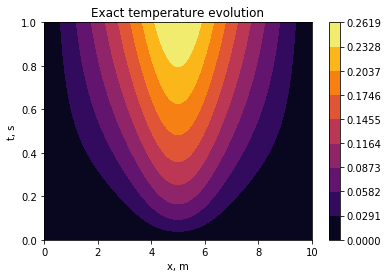

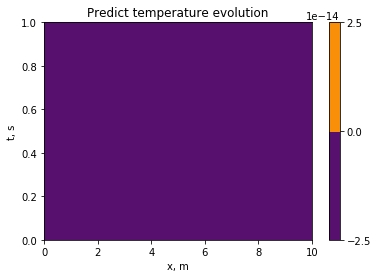

In [10]:
predict_temperature = model.predict([t_train, x_train])
predict_temperature = theta_scaler.inverse_transform(predict_temperature)

LEVELS_COUNT = 10

import matplotlib.pyplot as plt

time_mesh = list(np.unique(input_df["t"]))
x_mesh = list(np.unique(input_df["x"]))
temperature = input_df["theta"].to_numpy()
temperature = np.reshape(temperature, (len(time_mesh), len(x_mesh)))
predict_temperature = np.reshape(predict_temperature, (len(time_mesh), len(x_mesh)))

max_temp = np.max(temperature)
min_temp = np.min(temperature)

levels = [min_temp + (max_temp - min_temp) * i / (LEVELS_COUNT - 1) for i in range(LEVELS_COUNT)]

plt.contourf(x_mesh, time_mesh, temperature, levels = levels, cmap = 'inferno')
plt.ylabel('t, s')
plt.xlabel('x, m')
plt.title("Exact temperature evolution")
plt.colorbar()
plt.show()

plt.contourf(x_mesh, time_mesh, predict_temperature, cmap = 'inferno')
plt.ylabel('t, s')
plt.xlabel('x, m')
plt.title("Predict temperature evolution")
plt.colorbar()
plt.show()

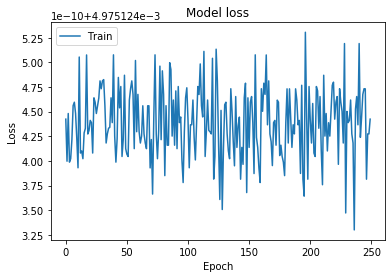

In [11]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [ ]:
theta_pred = model.predict([t_test, x_test])
print(model.predict([np.array([0]), np.array([0])]))
print(model.predict([np.array([1.0]), np.array([0.5])]))
print(theta_pred)
print(theta_test.values)


In [ ]:
#print(x_train)
data = model.predict([np.ones((100)), x_train[0:100]])


In [ ]:
plt.plot(data)
plt.grid()
plt.show()